# Parse Binance Market DataLoad downloaded market data from a given directory into a usable dataframe.

#### Fetch Latest Market Data

In [208]:
!docker-compose -f /Users/deanmartin/Source/fa.services.plutus/docker-compose.yml run --rm freqtrade download-data --exchange binance --days 1000 -t 1h


2021-10-10 15:10:39,358 - freqtrade.configuration.configuration - INFO - Using config: user_data/config.json ...
2021-10-10 15:10:39,362 - freqtrade.loggers - INFO - Verbosity set to 0
2021-10-10 15:10:39,363 - freqtrade.configuration.configuration - INFO - Using exchange binance
2021-10-10 15:10:39,622 - freqtrade.configuration.configuration - INFO - Using user-data directory: /freqtrade/user_data ...
2021-10-10 15:10:39,623 - freqtrade.configuration.configuration - INFO - Using data directory: /freqtrade/user_data/data/binance ...
2021-10-10 15:10:39,623 - freqtrade.configuration.configuration - INFO - timeframes --timeframes: ['1h']
2021-10-10 15:10:39,623 - freqtrade.configuration.configuration - INFO - Detected --days: 1000
2021-10-10 15:10:39,623 - freqtrade.configuration.check_exchange - INFO - Checking exchange...
2021-10-10 15:10:39,632 - freqtrade.configuration.check_exchange - INFO - Exchange "binance" is officially supported by the Freqtrade development team.
2021-10-10 15

#### Install & Import Dependencies

In [209]:
#brew install ta-lib

In [210]:
!pip install -U TA-Lib

In [211]:

from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import talib
from talib import MA_Type
from talib import RSI, BBANDS
import pickle

#### Functions to Assist with Data Parsing

In [212]:
def get_pair_name(path):
    pair_name = (path
                    .split('/')[-1]
                    .split('.json')[0]
                    .split('-')[0])
    
    return pair_name

def load_path_data(path):
    df = pd.read_json(path)
    df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    
    return df

#### Load & Parse Files

In [213]:
data_relative_path = '/Users/deanmartin/Source/fa.services.plutus/user_data/data/binance'
market_file_names = [ f for f in listdir(data_relative_path) if (isfile(join(data_relative_path, f)) and '.json' in f) ]
market_file_paths = np.array([f'{data_relative_path}/{f}' for f in market_file_names ])
market_data = { get_pair_name(path):load_path_data(path) for path in market_file_paths }

#### Featurize Data
For the features of the data we will add
- The top 5 indicator values.
- The hour of day.
- The day of week.
- The week of the year.
- The month of year.

In [214]:
def featurize_market_data(market_data):
    # Perform the transformation for each pair.
    for pair in market_data:
        # Featurizing pair "{pair}" with seasonality.
        pair_df = market_data[pair]
        pair_df['hour'] = pair_df.apply(lambda x: x['time'].hour, axis=1)
        pair_df['day'] = pair_df.apply(lambda x: x['time'].day, axis=1)
        pair_df['week'] = pair_df.apply(lambda x: x['time'].week, axis=1)
        pair_df['month'] = pair_df.apply(lambda x: x['time'].month, axis=1)
        
        # Featurizing pair "{pair}" with indicators.
        pair_df['sma'] = talib.SMA(pair_df['close'])
        time_periods = [ 14, 20]
        stds = [ 2, 3, 4 ]
        
        for period in time_periods:
            pair_df[f'rsi_tp{period}'] = RSI(pair_df['close'], timeperiod=period)
            pair_df['adx'] = talib.ADX(pair_df['high'], pair_df['low'], pair_df['close'], timeperiod=period)
            slowk, slowd = talib.STOCH(pair_df['high'], pair_df['low'], pair_df['close'], fastk_period=period)
            pair_df[f'stoch_slow_k_tp_{period}'] = slowk
            pair_df[f'stoch_slow_d_tp_{period}'] = slowd
            
            for deviation in stds:
                upper, middle, lower = BBANDS(pair_df['close'], timeperiod=period, nbdevup=deviation, nbdevdn=deviation, matype=0)
                pair_df[f'bb_upper_tp{period}_sd{deviation}'] = upper
                pair_df[f'bb_middle_tp{period}_sd{deviation}'] = middle
                pair_df[f'bb_lower_tp{period}_sd{deviation}'] = lower
        
    return market_data

#### Persist & Load Featurized Market Data

In [215]:
featurized_market_data = featurize_market_data(market_data)
model_file_path = './data/featurized_market_data.p'

In [216]:
with open(model_file_path, 'wb') as fp:
    pickle.dump(featurized_market_data, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [217]:
with open(model_file_path, 'rb') as fp:
    featurized_market_data = pickle.load(fp)

#### Sample Data

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

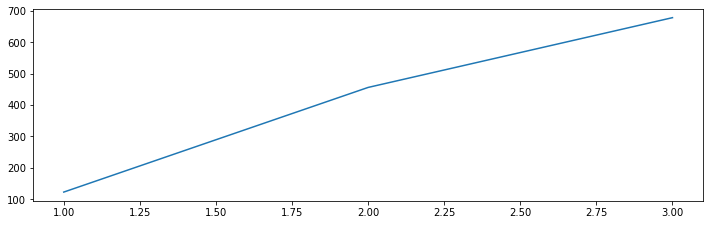

In [15]:
bch_data = featurized_market_data['BCH_BTC']

# We create our figure and specify the size:
fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot(3, 1, 1)

# We can now plot the data on each of the subplots:
ax1.plot([1,2,3], [123,456,678], label = 'Random Data')